# Wealth Distribution

James Sinclair - 1114278, Yujun Yan - 952112, Junkai Xing - 1041973

This notebook performs data analysis for validation of our Java implementation of the NetLogo wealth distribution model. The data analysis for the extension mechanism of inheritance is then provided.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import os

In [2]:
def plot_mean_envelope(df, colour, alpha=0.2):
    df_mean = df.transpose().describe().transpose()
    plt.fill_between(df.index, df_mean['mean'] - df_mean['std'], df_mean['mean'] + df_mean['std'], color=colour, alpha=alpha)
    plt.plot(df_mean['mean'], color=colour)


Let's plot the mean value +/- 1 standard deviation (computed for each tick) for both NetLogo and Java:

In [3]:
def summary_stats(dfs):
    stats = dfs.describe() \
              .transpose() \
              .describe()
    return stats[["mean", "std", "min", "max"]]


In [4]:
def compare(df_new, df_baseline):
    comparison = df_new.compare(df_baseline)
    df_comp = pd.DataFrame()
    for idx, data in comparison.groupby(level=0, axis=1):
        df_comp[idx] = data[idx]['self']/data[idx]['other'] - 1
    
    return df_comp

# Grain Distribution


Check that the initial distribution of grain produced by our model matches that of the NetLogo model

In [5]:
format_string = os.path.join("..", "netlogo-data", "initial-world-check", "Wealth Distribution world %d.csv")

nl_init_worlds = []

for i in range(1,6):
    filename = format_string % i
    df = pd.read_csv(filename, skiprows=265, nrows=51*51)[['grain-here', 'max-grain-here']]
    nl_init_worlds.append(df)

<AxesSubplot:ylabel='Frequency'>

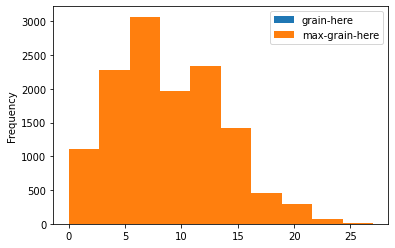

In [6]:
pd.concat(nl_init_worlds).reset_index(drop=True).plot(kind='hist', bins=10)

In [7]:
df_nl_grain = pd.concat(nl_init_worlds).reset_index(drop=True)['grain-here']
df_nl_grain = df_nl_grain.rename("netlogo-grain")
df_nl_grain

0        18
1        18
2        13
3         8
4         5
         ..
13000     9
13001    11
13002    10
13003     9
13004     8
Name: netlogo-grain, Length: 13005, dtype: int64

## Commit-c68b5867

<AxesSubplot:ylabel='Frequency'>

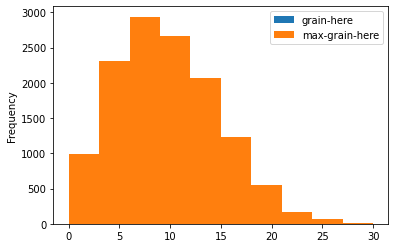

In [8]:
format_string = os.path.join("..", "java-data", "commit-c68b5867", "initial-patches", "patch-default-seed-%d.csv")

java_init_worlds = []

for i in range(0,5):
    filename = format_string % i
    df = pd.read_csv(filename)
    java_init_worlds.append(df)
    
pd.concat(java_init_worlds).reset_index(drop=True).plot(kind='hist', bins=10)

In [9]:
df_java_grain = pd.concat(java_init_worlds).reset_index(drop=True)['grain-here']
df_java_grain = df_java_grain.rename("java-grain")
df_java_grain

0        10.0
1         5.0
2         3.0
3         3.0
4         4.0
         ... 
13000     7.0
13001     8.0
13002     8.0
13003     7.0
13004     6.0
Name: java-grain, Length: 13005, dtype: float64

<AxesSubplot:title={'center':'Initial Grain Distribution'}, ylabel='Frequency'>

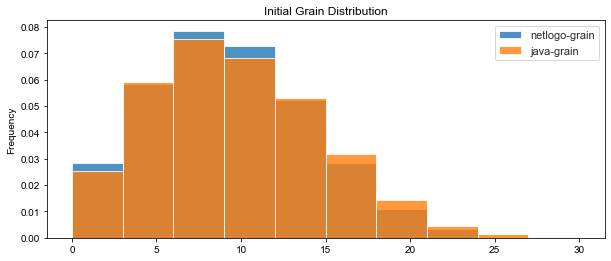

In [10]:
df_grain = pd.concat([df_nl_grain, df_java_grain], axis=1)
fig, axs = plt.subplots(1, 1)
fig.set_figwidth(10)
sns.set_theme(style="ticks")
df_grain.plot(kind='hist', bins=10, alpha=0.8, title='Initial Grain Distribution', density=True, ax=axs)

# Extension experiments

## Commit 59c5f258

### Validation

In [11]:
# Load java data
runs = ['default'] + list(range(2,13))
# number of people in each experiment
num_people = [250] * 12
num_people[1] = 1000
num_people[2] = 50
gini_constants =  [2.0/np for np in num_people]
print(gini_constants)

csv_format_string = "wealth-distrib-%s-seed-%s.csv"
data_file = os.path.join("..", "java-data", "commit-59c5f258", csv_format_string)

java_dfs = []
for run, gini_const in zip(runs, gini_constants):
    df = pd.DataFrame()
    for i in range(0,100):
        filename = data_file % (run, i)
        df_new = pd.read_csv(filename)
        df_new = df_new * gini_const
        df[f"gini-{i}"] = df_new['gini']
        
    java_dfs.append(df)

#java_dfs

[0.008, 0.002, 0.04, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008]


In [12]:
# load netlogo data
path = os.path.join('..', 'netlogo-data', 'netlogo-100-runs-%s.csv')

nl_dfs = []

for i, gini_const in zip(list(range(1,13)), gini_constants):
    filename = path % str(i)
    df = pd.read_csv(filename, skiprows=22)
    df = df.drop(['[all run data]'], axis=1)
    df = df * gini_const
    nl_dfs.append(df)
    
nl_dfs

[     gini-index-reserve  gini-index-reserve.1  gini-index-reserve.2  \
 0              0.281013              0.269873              0.277312   
 1              0.282392              0.273238              0.267487   
 2              0.290041              0.289286              0.282439   
 3              0.320849              0.304265              0.300055   
 4              0.324067              0.305867              0.307357   
 ..                  ...                   ...                   ...   
 496            0.515675              0.501049              0.525385   
 497            0.510578              0.502779              0.533839   
 498            0.517703              0.501473              0.534015   
 499            0.528670              0.512038              0.530048   
 500            0.502749              0.510990              0.518270   
 
      gini-index-reserve.3  gini-index-reserve.4  gini-index-reserve.5  \
 0                0.258538              0.251911            

Plot mean trendline +/- 1 stdev

Experiment: default
Experiment: 2
Experiment: 3
Experiment: 4
Experiment: 5
Experiment: 6
Experiment: 7
Experiment: 8
Experiment: 9
Experiment: 10
Experiment: 11
Experiment: 12


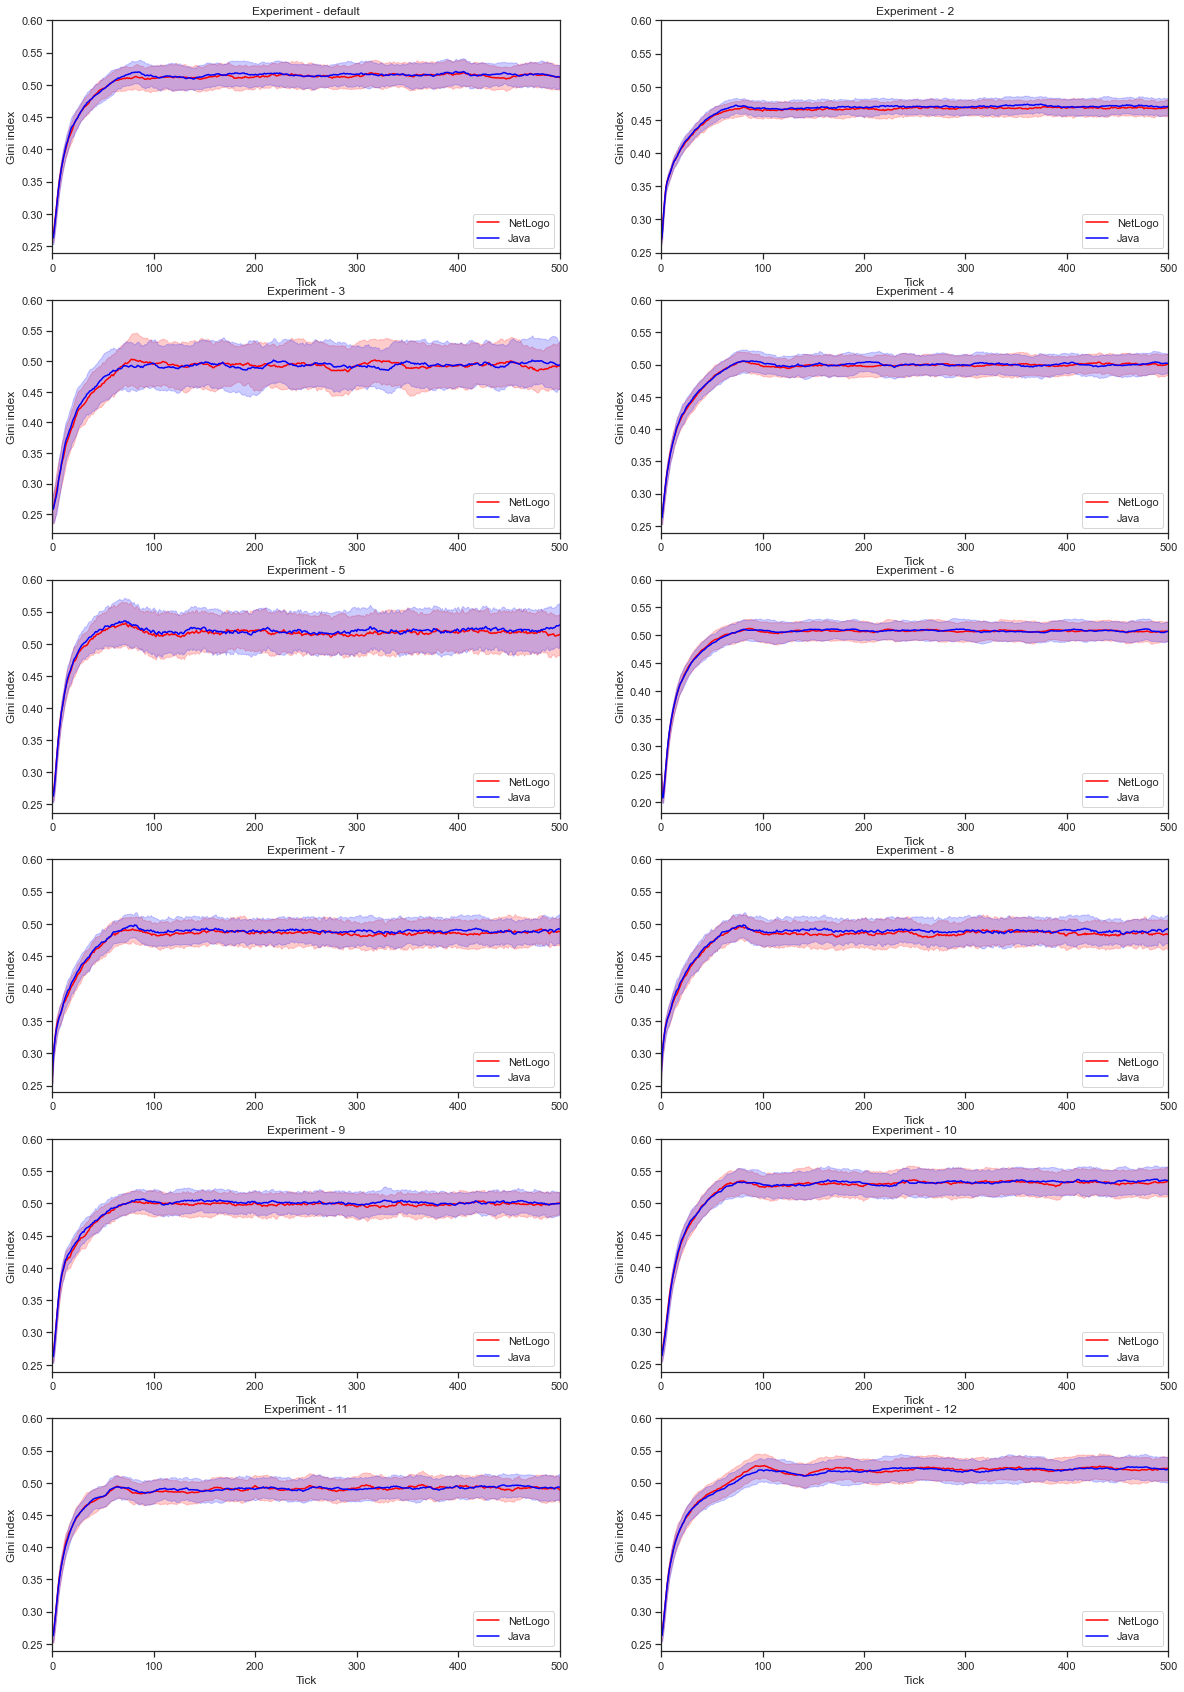

In [13]:
comp_df = pd.DataFrame()
i = 1
f = plt.figure()
f.subplots(6, 2)
f.set_figwidth(20)
f.set_figheight(30)

for (df_nl, df_j, run) in zip(nl_dfs, java_dfs, runs):
    plt.subplot(6, 2, i)
    i = i+1
    plot_mean_envelope(df_nl, 'red')
    plot_mean_envelope(df_j, 'blue')
    plt.xlim(left=0, right=500)
    plt.ylim(top=0.6)
    plt.xlabel('Tick')
    plt.ylabel('Gini index')
    plt.title('Experiment - ' + str(run))
    plt.legend(['NetLogo', 'Java'], loc='lower right')
    print("Experiment: " + str(run))
    comp_df[run] = compare(summary_stats(df_j), summary_stats(df_nl)).loc['mean']

Plot 1 trajectory for Java/NetLogo for each experiment

Experiment: default
Experiment: 2
Experiment: 3
Experiment: 4
Experiment: 5
Experiment: 6
Experiment: 7
Experiment: 8
Experiment: 9
Experiment: 10
Experiment: 11
Experiment: 12


Text(0, 0.5, 'Gini index')

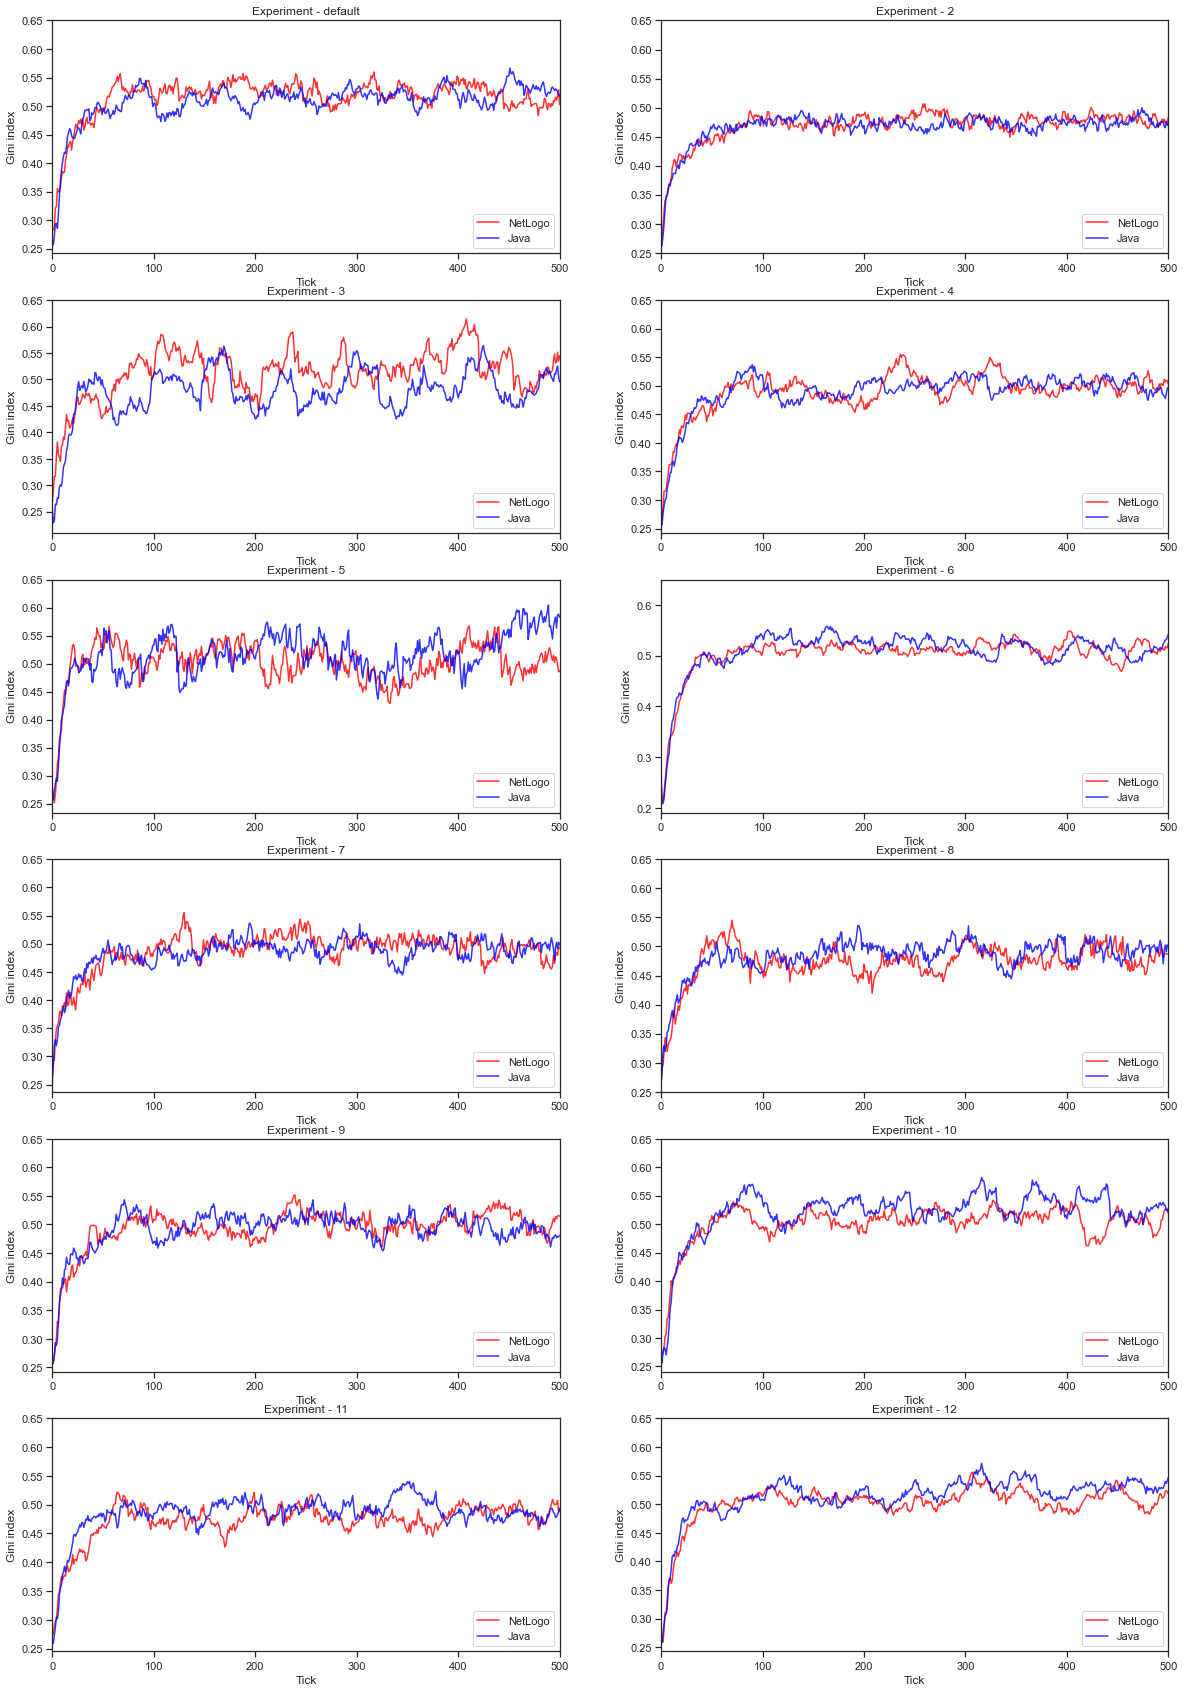

In [14]:
comp_df = pd.DataFrame()
i = 1
f = plt.figure()
f.subplots(6, 2)
f.set_figwidth(20)
f.set_figheight(30)

for (df_nl, df_j, run) in zip(nl_dfs, java_dfs, runs):
    plt.subplot(6, 2, i)
    i = i+1
    plt.plot(df_nl.iloc[:,0:1], alpha=0.8, color='red')
    plt.plot(df_j.iloc[:, 0:1], alpha=0.8, color='blue')
    plt.ylim(top=0.65)
    plt.xlim(left=0, right=500)
    plt.xlabel('Tick')
    plt.ylabel('Gini index')
    plt.title('Experiment - ' + str(run))
    plt.legend(['NetLogo', 'Java'], loc='lower right')
    print("Experiment: " + str(run))
    comp_df[run] = compare(summary_stats(df_j), summary_stats(df_nl)).loc['mean']


plt.xlabel('Tick')
plt.ylabel('Gini index')


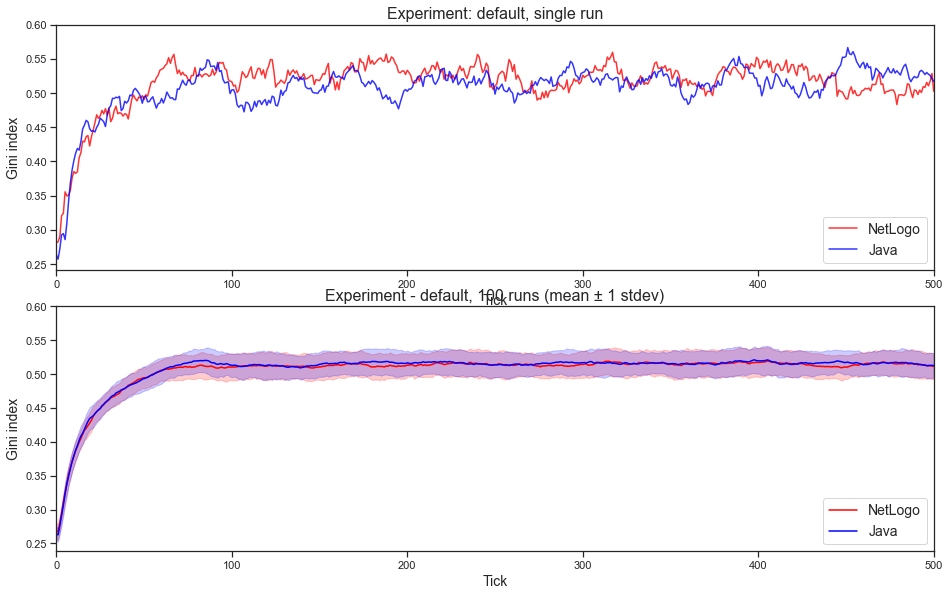

In [15]:
f = plt.figure()
f.subplots(2, 1)
f.set_figwidth(13)
f.set_figheight(8)
f.tight_layout()

exp = 0
df_nl = nl_dfs[exp]
df_j = java_dfs[exp]
run = runs[exp]

plt.subplot(2, 1, 1)
plt.plot(df_nl.iloc[:,0:1], alpha=0.8, color='red')
plt.plot(df_j.iloc[:, 0:1], alpha=0.8, color='blue')
plt.ylim(top=0.6)
plt.xlim(left=0, right=500)
plt.xlabel('Tick', fontsize=14)
plt.ylabel('Gini index', fontsize=14)
plt.title('Experiment: ' + str(run) + ', single run', fontsize=16)
plt.legend(['NetLogo', 'Java'], loc='lower right', fontsize=14)

plt.subplot(2, 1, 2)
plot_mean_envelope(df_nl, 'red')
plot_mean_envelope(df_j, 'blue')
plt.ylim(top=0.6)
plt.xlim(left=0, right=500)
plt.xlabel('Tick', fontsize=14)
plt.ylabel('Gini index', fontsize=14)
plt.title('Experiment - ' + str(run) + ', 100 runs (mean ± 1 stdev)', fontsize=16)
plt.legend(['NetLogo', 'Java'], loc='lower right', fontsize=14)


Plot % differences in mean/std deviation 

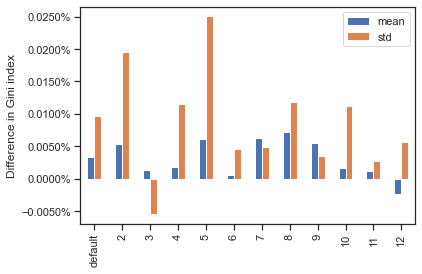

In [16]:
import matplotlib.ticker as mtick
ax = (comp_df).transpose()[['mean', 'std']].plot(kind='bar')
plt.ylabel('Difference in Gini index')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())

In [17]:
comp_df.to_csv('validation-comparison.csv')
(100*comp_df).round(2)

,default,2,3,4,5,6,7,8,9,10,11,12
max,0.37,0.38,-0.13,0.49,0.37,-0.10,0.46,0.47,0.22,0.18,-0.18,-0.07
mean,0.33,0.53,0.13,0.18,0.61,0.05,0.63,0.71,0.55,0.17,0.12,-0.24
min,-1.76,0.11,0.11,-0.64,-1.27,-1.84,-0.91,-1.01,-0.93,-0.91,-0.28,-1.11
std,0.96,1.95,-0.55,1.15,2.50,0.46,0.49,1.18,0.36,1.12,0.27,0.57


In [18]:
gini_nl_df = pd.DataFrame()
gini_j_df = pd.DataFrame()
for (df_nl, df_j, run) in zip(nl_dfs, java_dfs, runs):
    gini_j_df[run] = summary_stats(df_j)[['mean','std']].loc['mean'].rename(index={"mean": "java-mean", "std": "java-std"})
    gini_nl_df[run] = summary_stats(df_nl)[['mean','std']].loc['mean'].rename(index={"mean": "nl-mean", "std": "nl-std"})

gini_df = gini_j_df.transpose().join(gini_nl_df.transpose()).transpose()
gini_df

,default,2,3,4,5,6,7,8,9,10,11,12
java-mean,0.506273,0.463278,0.483737,0.491010,0.514401,0.497188,0.481209,0.481209,0.493233,0.521376,0.484261,0.508247
java-std,0.038079,0.026469,0.049956,0.036118,0.041663,0.043220,0.033948,0.033948,0.034328,0.042426,0.032950,0.039168
nl-mean,0.504585,0.460824,0.483095,0.490115,0.511281,0.496916,0.478212,0.477794,0.490553,0.520485,0.483690,0.509458
nl-std,0.037716,0.025963,0.050232,0.035708,0.040646,0.043021,0.033781,0.033554,0.034206,0.041956,0.032860,0.038947


In [19]:
gini_df.to_csv('validation-comparison-gini.csv')

## Extension - alternate mechanism

Metabolism + max(0, wealth)
commit commit-59c5f258

In [20]:
# Load java data
runs = ['default'] + list(range(2,13))
# number of people in each experiment
num_people = [250] * 12
num_people[1] = 1000
num_people[2] = 50
gini_constants =  [2.0/np for np in num_people]
print(gini_constants)

csv_format_string = "wealth-distrib-%s-seed-%s-inheritance.csv"
data_file = os.path.join("..", "java-data", "commit-59c5f258", csv_format_string)

ext_dfs = []
for run, gini_const in zip(runs, gini_constants):
    df = pd.DataFrame()
    for i in range(0,100):
        filename = data_file % (run, i)
        df_new = pd.read_csv(filename)
        df_new = df_new * gini_const
        df[f"gini-{i}"] = df_new['gini']
        
    ext_dfs.append(df)

#ext_dfs

[0.008, 0.002, 0.04, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008, 0.008]


In [21]:
pd.concat(ext_dfs).reset_index(drop=True).max()

gini-0     0.931287
gini-1     0.889440
gini-2     0.921068
gini-3     0.915791
gini-4     0.873189
             ...   
gini-95    0.869199
gini-96    0.909023
gini-97    0.912685
gini-98    0.841441
gini-99    0.886820
Length: 100, dtype: float64

Experiment: default
Experiment: 2
Experiment: 3
Experiment: 4
Experiment: 5
Experiment: 6
Experiment: 7
Experiment: 8
Experiment: 9
Experiment: 10
Experiment: 11
Experiment: 12


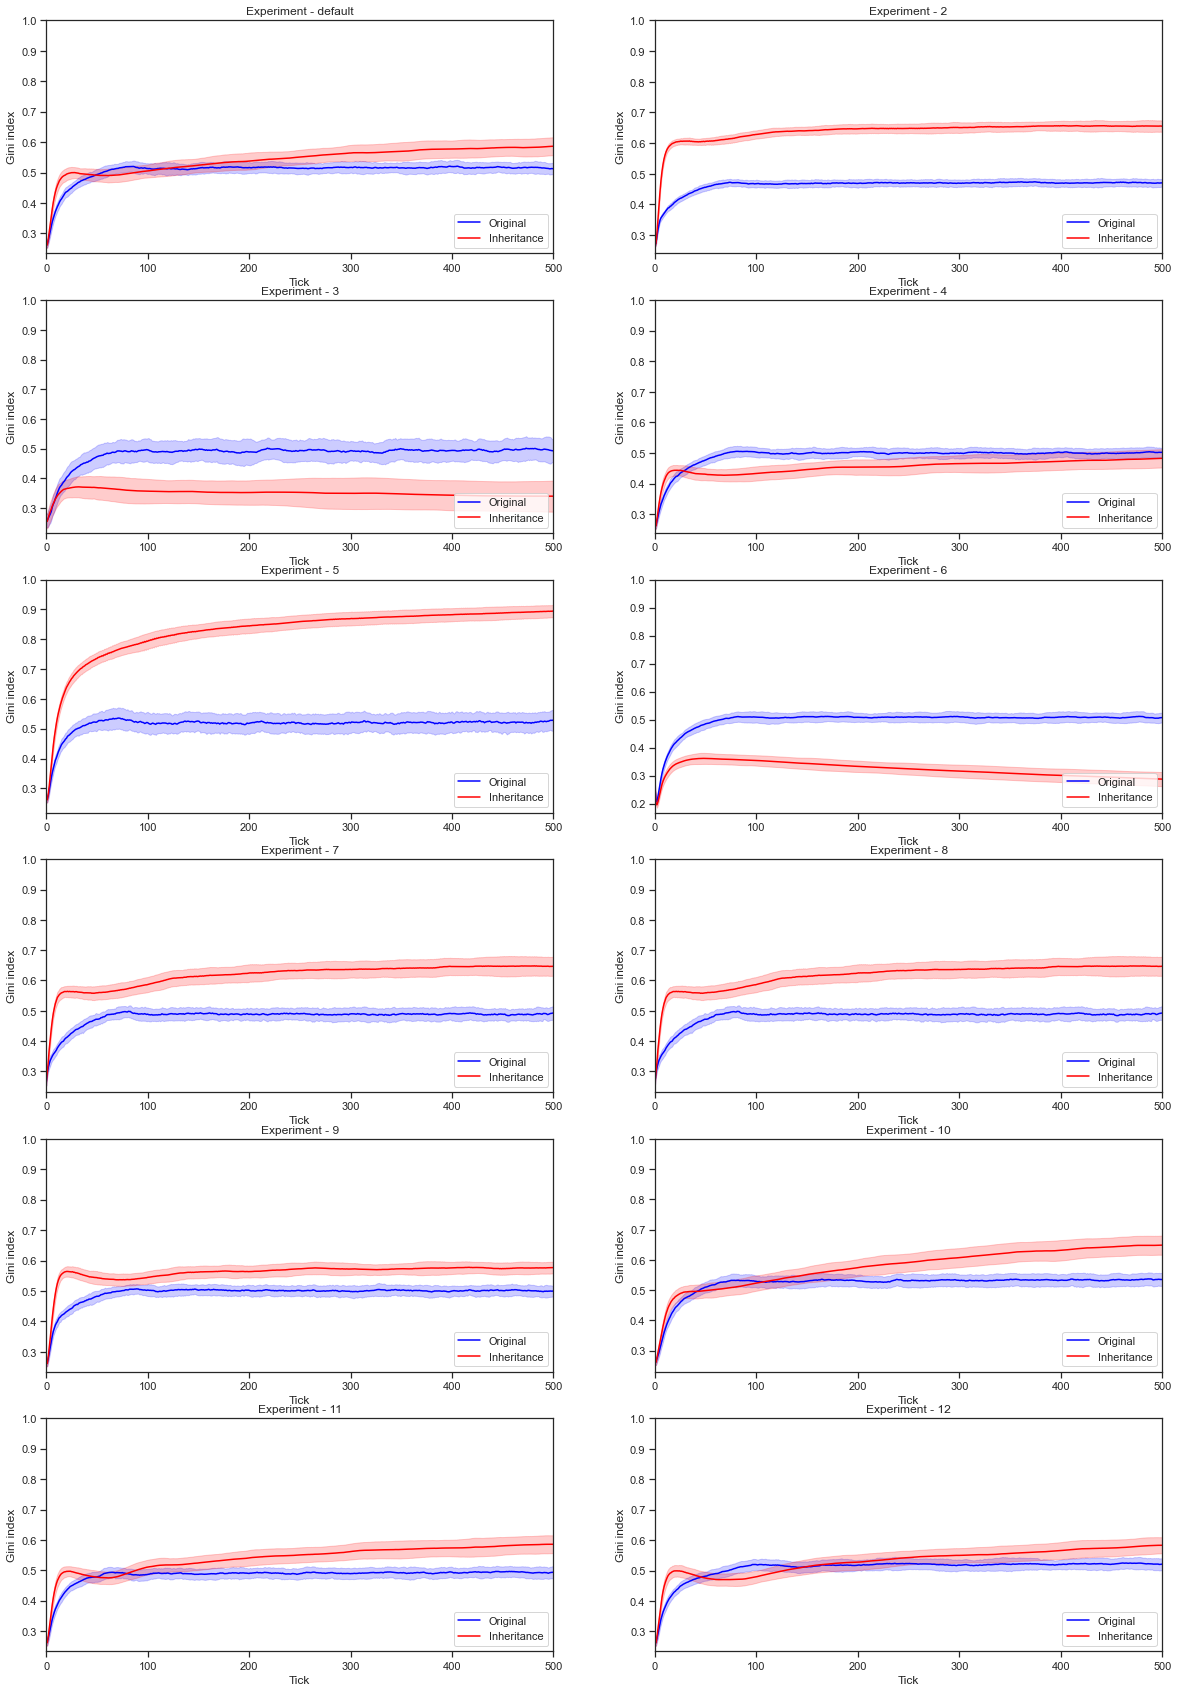

In [22]:
comp_df = pd.DataFrame()
i = 1
f = plt.figure()
f.subplots(6, 2)
f.set_figwidth(20)
f.set_figheight(30)

for (df_e, df_j, run) in zip(ext_dfs, java_dfs, runs):
    plt.subplot(6, 2, i)
    i = i+1
    plot_mean_envelope(df_j, 'blue')
    plot_mean_envelope(df_e, 'red')
    plt.ylim(top=1.0)
    plt.xlim(left=0, right=500)
    plt.xlabel('Tick')
    plt.ylabel('Gini index')
    plt.title('Experiment - ' + str(run))
    plt.legend(['Original', 'Inheritance'], loc='lower right')
    print("Experiment: " + str(run))
    comp_df[run] = compare(summary_stats(df_j), summary_stats(df_e)).loc['mean']

Experiment: default
Experiment: 2
Experiment: 3
Experiment: 4
Experiment: 5
Experiment: 6
Experiment: 7
Experiment: 8
Experiment: 9
Experiment: 10
Experiment: 11
Experiment: 12


Text(0, 0.5, 'Gini index')

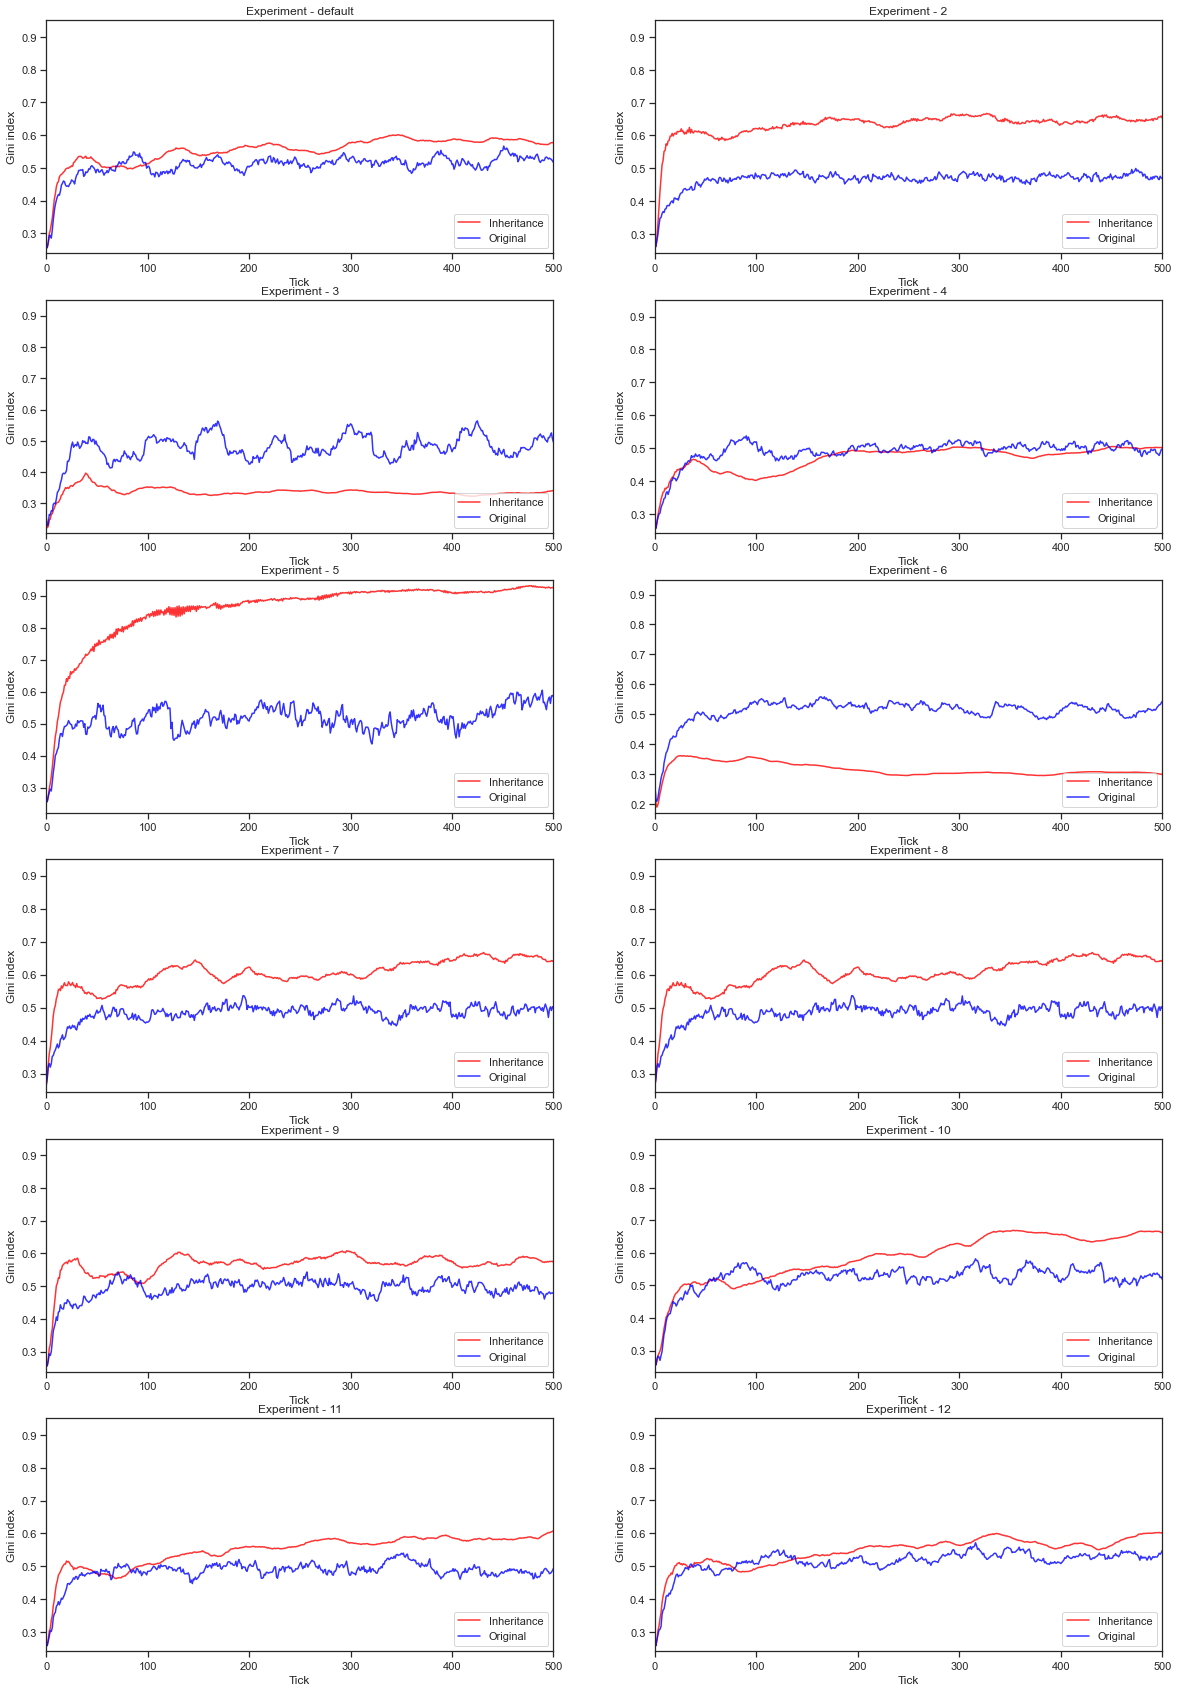

In [23]:
comp_df = pd.DataFrame()
i = 1
f = plt.figure()
f.subplots(6, 2)
f.set_figwidth(20)
f.set_figheight(30)

for (df_e, df_j, run) in zip(ext_dfs, java_dfs, runs):
    plt.subplot(6, 2, i)
    
    i = i+1
    plt.plot(df_e.iloc[:,0:1], alpha=0.8, color='red')
    plt.plot(df_j.iloc[:, 0:1], alpha=0.8, color='blue')
    plt.ylim(top=0.95)
    plt.xlim(left=0, right=500)
    plt.xlabel('Tick')
    plt.ylabel('Gini index')
    plt.title('Experiment - ' + str(run))
    plt.legend(['Inheritance', 'Original'], loc='lower right')
    print("Experiment: " + str(run))
    comp_df[run] = compare(summary_stats(df_e), summary_stats(df_j)).loc['mean']


plt.xlabel('Tick')
plt.ylabel('Gini index')


In [24]:
comp_df = pd.DataFrame()

for (df_e, df_j, run) in zip(ext_dfs, java_dfs, runs):
    comp_df[run] = compare(summary_stats(df_e.loc[400:501]), summary_stats(df_j.loc[400:501])).loc['mean']


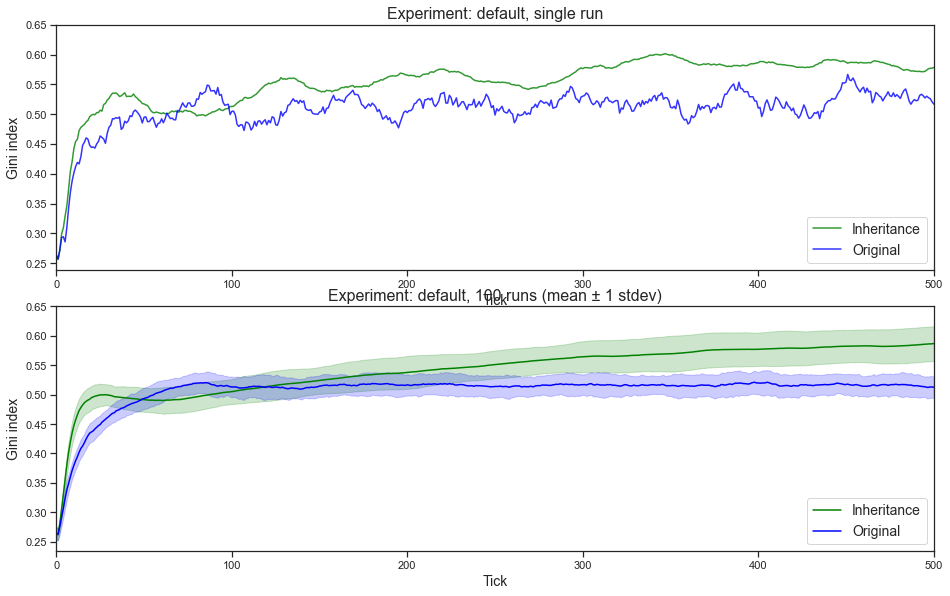

In [25]:
f = plt.figure()
f.subplots(2, 1)
f.set_figwidth(13)
f.set_figheight(8)
f.tight_layout()
#f.suptitle('Experiment: Default')
exp = 0
df_e = ext_dfs[exp]
df_j = java_dfs[exp]
run = runs[exp]

plt.subplot(2, 1, 1)

plt.plot(df_e.iloc[:,0:1], alpha=0.8, color='green')
plt.plot(df_j.iloc[:, 0:1], alpha=0.8, color='blue')
plt.ylim(top=0.65)
plt.xlim(left=0, right=500)
plt.xlabel('Tick', fontsize=14)
plt.ylabel('Gini index', fontsize=14)
plt.title('Experiment: ' + str(run) + ', single run', fontsize=16)
plt.legend(['Inheritance', 'Original'], loc='lower right', fontsize=14)

plt.subplot(2, 1, 2)
plot_mean_envelope(df_e, 'green')
plot_mean_envelope(df_j, 'blue')
plt.ylim(top=0.65)
plt.xlim(left=0, right=500)
plt.xlabel('Tick', fontsize=14)
plt.ylabel('Gini index', fontsize=14)
plt.title('Experiment: ' + str(run) + ', 100 runs (mean ± 1 stdev)', fontsize=16)
plt.legend(['Inheritance', 'Original'], loc='lower right', fontsize=14)



Text(0.5, 1.0, 'Effect of inheritance')

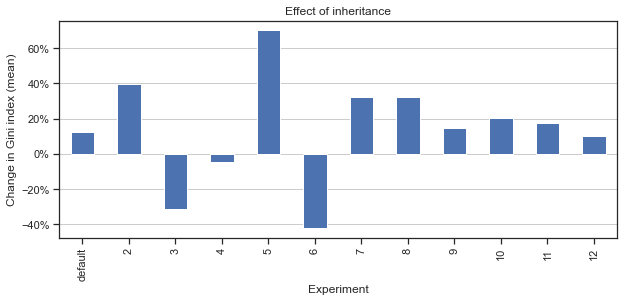

In [26]:
import matplotlib.ticker as mtick
f = plt.figure()
f.set_figwidth(10)
ax = (comp_df*100).transpose()['mean'].plot(kind='bar')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_axisbelow(True)
plt.grid(True, axis='y')
plt.ylabel('Change in Gini index (mean)')
plt.xlabel('Experiment')
plt.title('Effect of inheritance')

# description: change in mean Gini index from tick 400-500

Text(0.5, 1.0, 'Effect of inheritance')

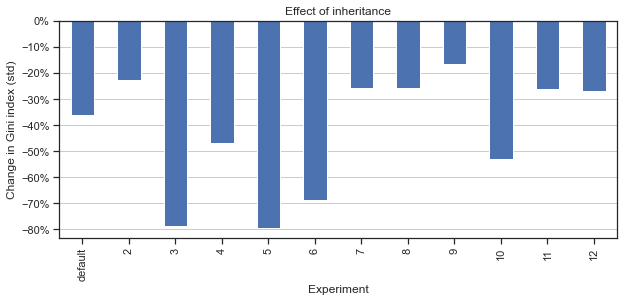

In [27]:
import matplotlib.ticker as mtick
f = plt.figure()
f.set_figwidth(10)
ax = (comp_df*100).transpose()['std'].plot(kind='bar')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_axisbelow(True)
plt.grid(True, axis='y')
plt.ylabel('Change in Gini index (std)')
plt.xlabel('Experiment')
plt.title('Effect of inheritance')

In [28]:
comp_df.to_csv('extension-comparison.csv')
(100*comp_df).round(2)

,default,2,3,4,5,6,7,8,9,10,11,12
max,8.70,36.16,-37.00,-7.55,55.62,-44.07,27.29,27.29,11.98,15.09,13.62,7.42
mean,12.60,39.36,-31.15,-4.54,69.97,-42.12,32.32,32.32,14.89,20.29,17.49,10.08
min,17.30,42.57,-23.25,-1.19,88.42,-40.00,38.77,38.77,18.70,25.91,21.79,13.36
std,-36.19,-22.61,-78.83,-47.05,-79.30,-68.89,-25.92,-25.92,-16.54,-53.02,-26.28,-27.00


In [29]:
gini_e_df = pd.DataFrame()
gini_j_df = pd.DataFrame()
for (df_e, df_j, run) in zip(ext_dfs, java_dfs, runs):
    gini_j_df[run] = summary_stats(df_j)[['mean','std']].loc['mean'].rename(index={"mean": "original-mean", "std": "original-std"})
    gini_e_df[run] = summary_stats(df_e)[['mean','std']].loc['mean'].rename(index={"mean": "inheritance-mean", "std": "inheritance-std"})

gini_df = gini_j_df.transpose().join(gini_e_df.transpose()).transpose()
gini_df

,default,2,3,4,5,6,7,8,9,10,11,12
original-mean,0.506273,0.463278,0.483737,0.491010,0.514401,0.497188,0.481209,0.481209,0.493233,0.521376,0.484261,0.508247
original-std,0.038079,0.026469,0.049956,0.036118,0.041663,0.043220,0.033948,0.033948,0.034328,0.042426,0.032950,0.039168
inheritance-mean,0.540877,0.637540,0.350685,0.454444,0.827113,0.322247,0.616097,0.616097,0.561157,0.577181,0.539737,0.529749
inheritance-std,0.046798,0.040808,0.028083,0.028920,0.093033,0.028357,0.046641,0.046641,0.036944,0.065786,0.047020,0.046911


In [30]:
gini_df.to_csv('validation-comparison-gini.csv')